In [9]:
import numpy as np
import pandas as pd
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis
import matplotlib.pyplot as plt
import fklab.signals.multitaper as mt
import scipy.signal
import fklab.signals.filter

%matplotlib notebook

plt.style.use('seaborn-ticks')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import itertools
import re
import h5py

from fklab.io.data import import_position
from fklab.io.data import import_environment

import fklab.segments as segments
from fklab.segments import Segment

from fklab.signals.smooth import kernelsmoothing
from fklab.behavior import task_analysis



In [10]:
position_data = h5py.File('/media/kasia/K/Neuropixeldata/Th1_ca3_9/2019-11-29_13-20-45/epochs/training/position.hdf5', 'r')

# diodes = position_data['diodes'].value
head_direction = np.array(position_data['head_direction'])
position = np.array(position_data['position'])
time = np.array(position_data['time'])
velocity = np.array(position_data['velocity'])

print(velocity)


[nan+nanj nan+nanj nan+nanj ... nan+nanj nan+nanj nan+nanj]


In [11]:
import ruamel_yaml

position_yaml_file = '/media/kasia/K/Neuropixeldata/Th1_ca3_9/2019-11-29_13-20-45/epochs/training/position.yaml'
with open(position_yaml_file) as f:
    position_yaml = ruamel_yaml.YAML().load(f)
    

In [4]:
list(position_yaml)


['raw_data',
 'time_windows',
 'source',
 'tracking',
 'regions',
 'jumps',
 'small_gaps',
 'diode_distance',
 'missing_diode',
 'large_gaps',
 'behavior']

In [12]:
#here we access the keys of the dictionary position_yaml
epoch = position_yaml['source']['epoch']
epoch
open_box_epoch = [12033, 13828]
linear_track_epoch = [13883, 14456]
sleep_box_epoch = [14502, 15686]


In [13]:
#you create an array for time and add a scalar value to it,
#each scalar value will be added to every value in the array
time = np.array(time)
corrected_time = time + 6

In [14]:
environment_yaml_file = '/media/kasia/K/Neuropixeldata/Th1_ca3_9/2019-11-29_13-20-45/epochs/training/environment.yaml'
with open(environment_yaml_file) as f:
    environment_yaml = ruamel_yaml.YAML().load(f)
    
list(environment_yaml)

['open_box', 'linear_track']

In [15]:
from fklab.geometry.shapes import rectangle


open_box_data = environment_yaml['open_box']['shapes']['open_box']['shape']
open_box = rectangle(**open_box_data)
open_box


rectangle (size=[228.0,250.0], center=[375.0,236.0], orientation=0.0 rad)

<IPython.core.display.Javascript object>


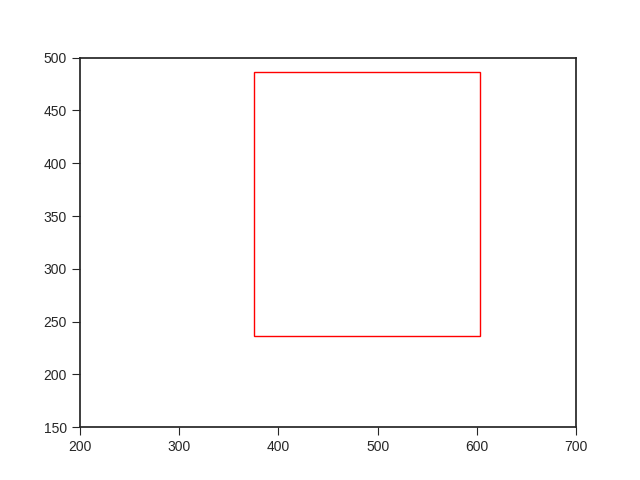

(375.0, 236.0)

In [16]:
from fklab.plot.core.interaction import Rectangle

open_box_i = Rectangle(open_box.center, *open_box.size, open_box.orientation, fill=False, color='r')

plt.gca().add_artist(open_box_i)
plt.xlim(200, 700)
plt.ylim(150, 500)

open_box_i.xy



In [17]:
from  fklab.geometry.shapes import polyline

linear_track_data = environment_yaml['linear_track']['shapes']['linear_track']['shape']['polylines'][0]
linear_track = polyline(**linear_track_data)
linear_track
    
#     class fklab.geometry.shapes.polyline(vertices=[], spline=False, **kwargs)

straight polyline with 2 vertices

<IPython.core.display.Javascript object>


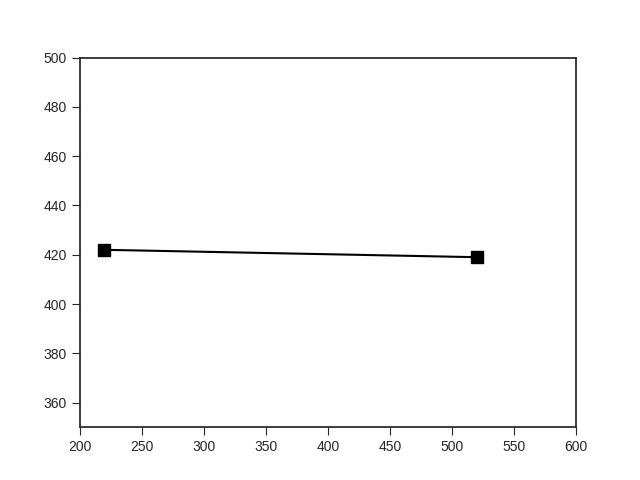

(350, 500)

In [18]:
from fklab.plot.core.interaction import iPolyline
linear_track_i = iPolyline(linear_track.vertices, color='k')
plt.gca().add_artist(linear_track_i)
plt.xlim(200, 600)
plt.ylim(350, 500)

# class fklab.plot.core.interaction.iPolyline(xy, **kwargs)

<IPython.core.display.Javascript object>


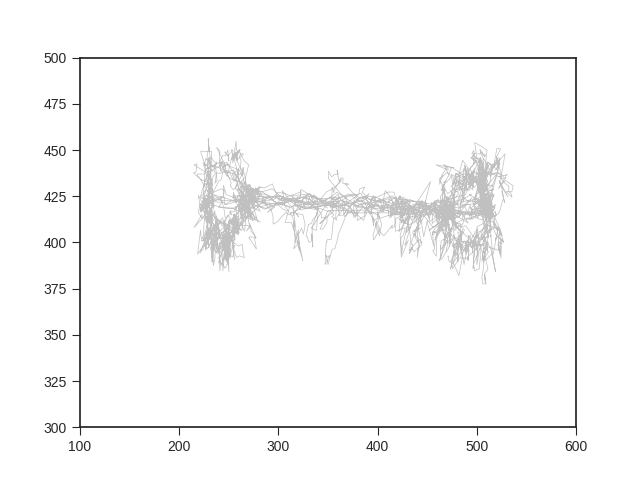

In [19]:
# position_ob = position[np.logical_and(time > open_box_epoch[0],
#                                       time < open_box_epoch[1]), :]
# position_ob

# plt.plot(position_ob[:, 0], position_ob[:, 1], color='silver', lw=0.5)
# plt.xlim(100, 600)
# plt.ylim(100, 400)
# plt.figsave('ob_trajectory2911.png')

position_lt = position[np.logical_and(time > linear_track_epoch[0],
                                      time < linear_track_epoch[1]), :]
position_lt

plt.plot(position_lt[:, 0], position_lt[:, 1], color='silver', lw=0.5)
plt.xlim(100, 600)
plt.ylim(300, 500)
plt.savefig('lt_trajectory2911.png')

<IPython.core.display.Javascript object>


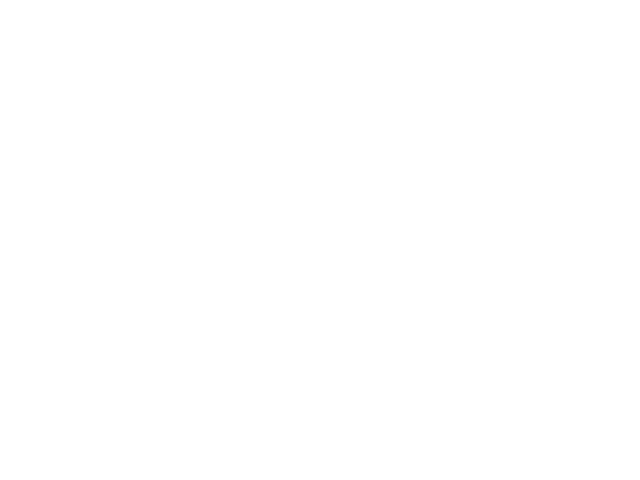

NameError: name 'spike_ts' is not defined

In [20]:
# from scipy.stats import binned_statistic_2d

# x = position_ob[:, 0]
# y = position_ob[:, 1]
# mask = ~np.logical_or(np.isnan(x), np.isnan(y))

# pos_bin = scipy.stats.binned_statistic_2d(x[mask], 
#                                           y[mask], 
#                                           np.ones_like(x), 
#                                           statistic='count', 
#                                           bins=100)[0]

# import fklab.signals.smooth as smooth

# #create kernel
# K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
# S = smooth.Smoother(K)
# pos_bin_smoothed = S(pos_bin)

# plt.imshow(pos_bin_smoothed, cmap='gnuplot')
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('#of visits', rotation=270, fontsize=20, verticalalignment="bottom")
# plt.savefig('occupancy_map_2911_openbox.png')


from scipy.stats import binned_statistic_2d

x = position_lt[:, 0]
y = position_lt[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

pos_bin = scipy.stats.binned_statistic_2d(x[mask], 
                                          y[mask], 
                                          np.ones_like(x), 
                                          statistic='count', 
                                          bins=40)[0]

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K)
pos_bin_smoothed = S(pos_bin)

plt.imshow(pos_bin_smoothed, cmap='gnuplot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('#of visits', rotation=270, fontsize=20, verticalalignment="bottom")
plt.savefig('occupancy_map_2911_linear_track.png')


binned = scipy.stats.binned_statistic(spike_ts, np.ones_like(spike_ts), 
                                               statistic='count',
                                               bins=(spile_time_range[1] - spile_time_range[0]), 
                                               range=None)[0]


In [21]:
Fs = 30000.0

In [22]:
project_root = '/media/kasia/K/Neuropixeldata/Th1_ca3_9/catgt_29112019_g0/'

clusters = np.load(project_root + "spike_clusters.npy")
#print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")
y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [23]:
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
# print(data)
# print(data['channel'])
#print(data[data['KSLabel'] == 'good'])
all_data_good = data[data['KSLabel']== 'good']
data_good = data[data['group'] == 'good']
#print(data_good)
depth = all_data_good['depth']

latsep = data_good[data_good['depth'] >3000]
depthLS = latsep['depth']
n_spkLS = latsep['n_spikes']
depth = data_good['depth']
n_spk = data_good['n_spikes']
channel = data_good['channel']

cluster_depth = data_good['depth']

sort_index = list(sorted(filter(lambda it: cluster_depth[it] > 3000,
                               range(len(id_s))), 
                         key=lambda it: cluster_depth[it]))

NameError: name 'id_s' is not defined

617985
0.0 1.20253164556962


<IPython.core.display.Javascript object>


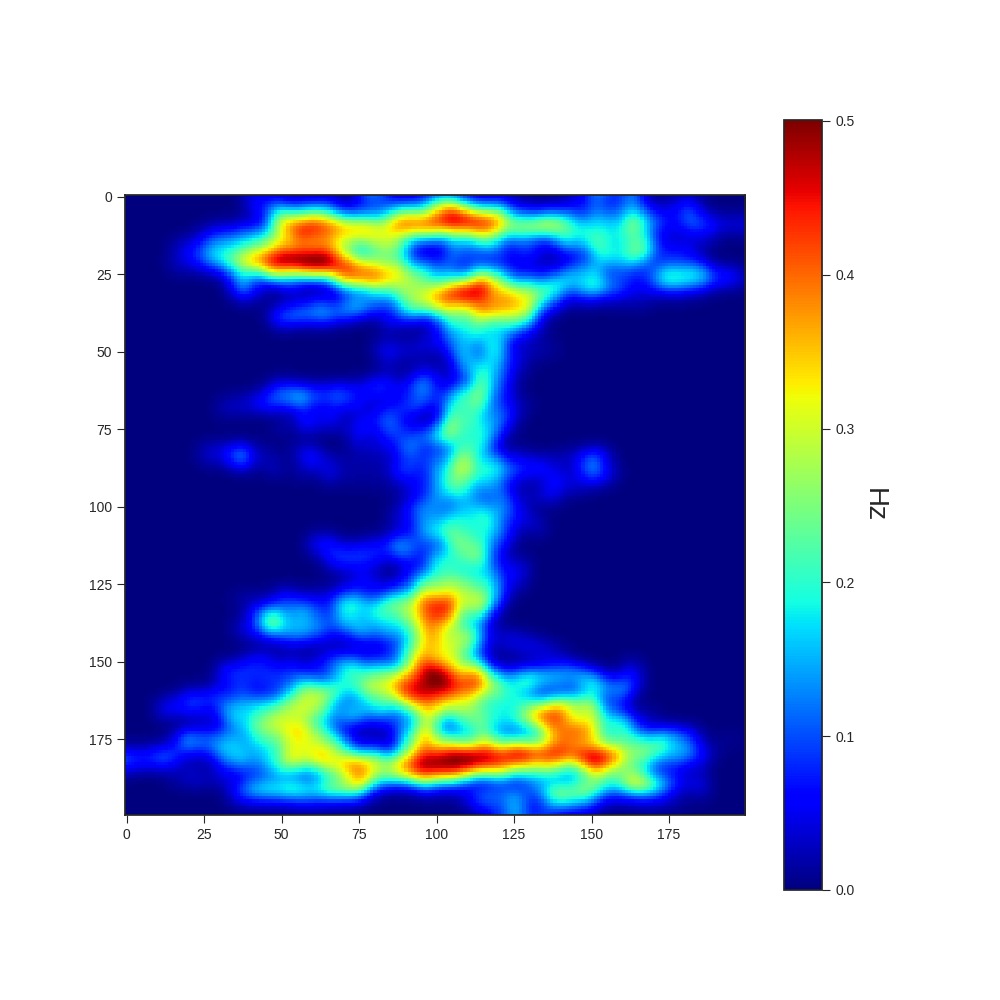

In [24]:
#open box
spike_t = []
spike_time_range = np.array(open_box_epoch) - open_box_epoch[0]  + 6
# print(spike_time_range)

plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(data_good['id']):
#     print('cluster_id', cluster_id)
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spike_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

print(len(spike_t))
spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(data_good['id']), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(x[mask], 
                                            y[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=200)[0]

spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)

plt.imshow(spike_bin_smoothed, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
plt.savefig('firingrate_2911_open_box.png')


6491
0.0 8.0


<IPython.core.display.Javascript object>


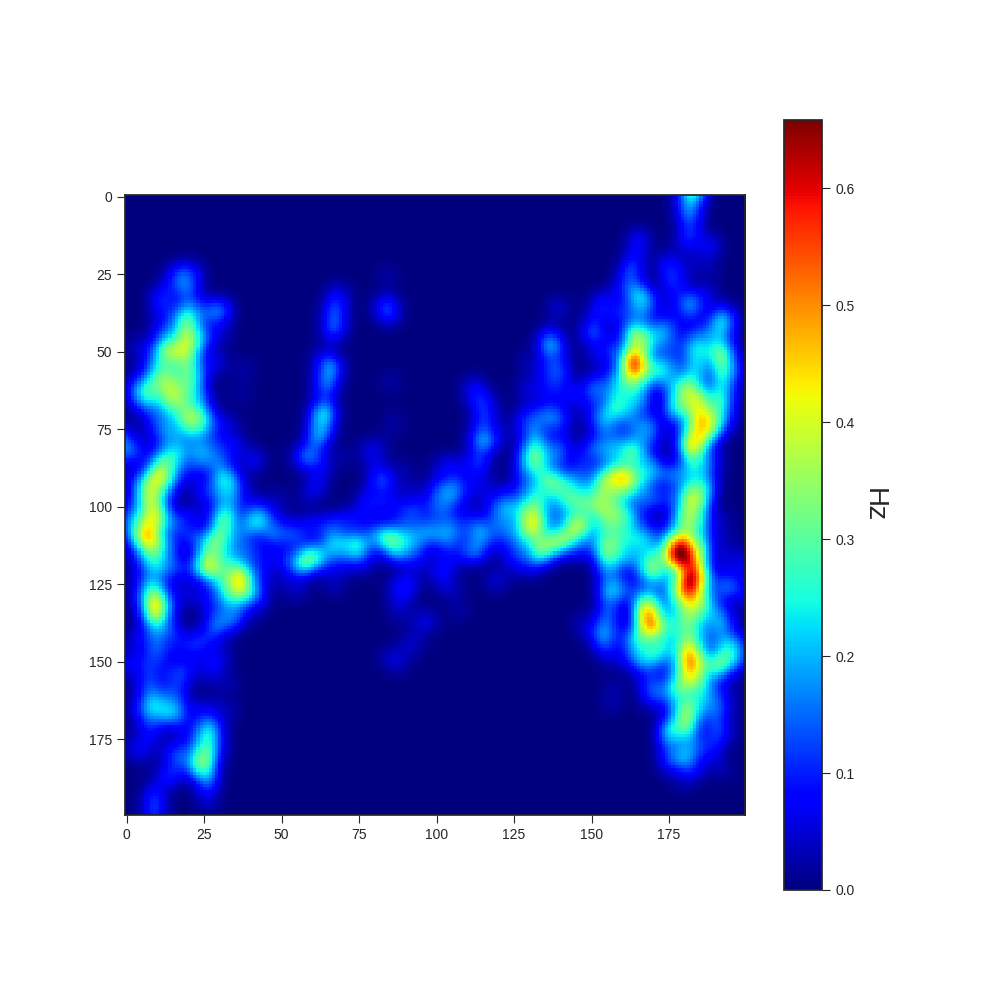

Text(0, 0.5, 'Hz')

In [25]:
#linear track
spike_t = []
spike_time_range = np.array(linear_track_epoch) - linear_track_epoch[0]  + 6
# print(spike_time_range)
picked_channel = [365]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(data_good['id']):
#     print('cluster_id', cluster_id)
    if channel[cluster_index] not in picked_channel:
        continue
        
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spike_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

print(len(spike_t))
spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=200)[0]

spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)

plt.imshow(spike_bin_smoothed, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
# plt.savefig('firingrate_2911_open_box.png')


In [26]:
mask_lt = np.logical_and(time > linear_track_epoch[0],
                                      time < linear_track_epoch[1])
position_lt = position[mask_lt, :]
position_lt
linear_track_epoch
x = position_lt[:, 0]
y = position_lt[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

dx = np.diff(x)
dy = np.diff(y)
distance = np.sqrt(dx**2 + dy**2)
speed = distance / np.diff(time[mask_lt])   

d = np.zeros((len(x), 2))
vel = np.zeros_like(d)

for i in range(1, len(position_lt)-1):
    d[i, :] = (x[i+1] - x[i-1] , y[i+1] - y[i-1])
    vel[i, :] = d[i] / time[mask_lt][i]
print(d[5])
print(vel[100])


# plt.plot(speed, time[mask_lt][1:])
# plt.hist(speed, time[mask_lt][1:], bins=10)        

[-1.99550996 -1.98656301]
[ 2.05593857e-04 -7.18065636e-05]


In [287]:
position_lt.shape

(14325, 2)